# ECG Heartbeat Classifier (Decision Tree vs Bagging)

## What this notebook does
We train two models on the ECG Heartbeat Categorization dataset:
1. A **single Decision Tree** (baseline)
2. A **Bagging ensemble** of Decision Trees

## Why Bagging?
Decision Trees often overfit (high variance). **Bagging** trains many trees on bootstrap samples and aggregates their predictions to improve generalization.

### Step 1 — Imports & Setup

In [44]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Step 2 - DataSet Paths
We will load the ECG dataset CSVs from the folders needed for this project

In [45]:
DATA_DIR = 'archive'
train_path = os.path.join(DATA_DIR, 'mitbih_train.csv')
test_path = os.path.join(DATA_DIR, 'mitbih_test.csv')

print("Train Path:", train_path, "| exists:", os.path.exists(train_path))
print("Test Path:", test_path, "| exists:", os.path.exists(test_path))

Train Path: archive/mitbih_train.csv | exists: True
Test Path: archive/mitbih_test.csv | exists: True


### Step 3 - Load the CSVs
Each row is one heartbeat sample.
The last column is the label (class)

In [46]:
df_train = pd.read_csv(train_path, header=None)
df_test = pd.read_csv(test_path, header=None)

print("train shape:", df_train.shape)
print("test shape:", df_test.shape)

# A Quick Peak
display(df_train.head())
print("Unique labels in train:", sorted(df_train.iloc[:, -1].unique()))

train shape: (87554, 188)
test shape: (21892, 188)


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Unique labels in train: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0)]


### DataSet Evaluation

Goal: understand shape, labels, missing values, duplicates, value ranges, and potential noise/outliers.

We will also visualize:
- Class distribution (train vs test)
- Example ECG beats per class
- Overall value distribution (histogram)
- Feature summary patterns (mean/std across timepoints)
- Quick outlier checks (values outside expected range)

In [47]:
# Last column is the label
X_train = df_train.iloc[:, :-1].astype(float)
y_train = df_train.iloc[:, -1].astype(int)

X_test  = df_test.iloc[:, :-1].astype(float)
y_test  = df_test.iloc[:, -1].astype(int)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test :", X_test.shape,  "y_test :", y_test.shape)
print("Classes (train):", sorted(y_train.unique()))
print("Classes (test) :", sorted(y_test.unique()))


X_train: (87554, 187) y_train: (87554,)
X_test : (21892, 187) y_test : (21892,)
Classes (train): [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Classes (test) : [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]


In [48]:
display(df_train.head())
print("\nDtypes (train):")
print(df_train.dtypes.value_counts())


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Dtypes (train):
float64    188
Name: count, dtype: int64


In [49]:
# Now to look for the Missing Values
missing_train = df_train.isna().sum().sum()
missing_test  = df_test.isna().sum().sum()

print("Missing values (train):", missing_train)
print("Missing values (test) :", missing_test)

# If we want per-column:
missing_per_col = df_train.isna().sum()
print("Columns with missing (train):", (missing_per_col > 0).sum())

Missing values (train): 0
Missing values (test) : 0
Columns with missing (train): 0


In [50]:
# Let's Check for Duplicates
dup_train = df_train.duplicated().sum()
dup_test  = df_test.duplicated().sum()
print("Duplicate rows (train):", dup_train)
print("Duplicate rows (test) :", dup_test)


Duplicate rows (train): 0
Duplicate rows (test) : 0


In [51]:
# Lets have a look at the label Distribution
# More like we are looking for class imbalances
y_train = df_train.iloc[:, -1].astype(int)
y_test  = df_test.iloc[:, -1].astype(int)

print("Unique labels (train):", sorted(y_train.unique()))
print("\nTrain label counts:")
print(y_train.value_counts().sort_index())

print("\nTest label counts:")
print(y_test.value_counts().sort_index())

Unique labels (train): [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]

Train label counts:
187
0    72471
1     2223
2     5788
3      641
4     6431
Name: count, dtype: int64

Test label counts:
187
0    18118
1      556
2     1448
3      162
4     1608
Name: count, dtype: int64


In [52]:
# Now for Feature Summary
X_train = df_train.iloc[:, :-1].astype(float)

summary = X_train.describe().T  # count, mean, std, min, 25%, 50%, 75%, max
display(summary.head(10))
print("Any columns with zero variance?", (summary["std"] == 0).sum())

,count,mean,std,min,25%,50%,75%,max
0,87554.0,0.890360,0.240909,0.0,0.921922,0.991342,1.000000,1.0
1,87554.0,0.758160,0.221813,0.0,0.682486,0.826013,0.910506,1.0
2,87554.0,0.423972,0.227305,0.0,0.250969,0.429472,0.578767,1.0
3,87554.0,0.219104,0.206878,0.0,0.048458,0.166000,0.341727,1.0
4,87554.0,0.201127,0.177058,0.0,0.082329,0.147878,0.258993,1.0
5,87554.0,0.210399,0.171909,0.0,0.088416,0.158798,0.287628,1.0
6,87554.0,0.205808,0.178481,0.0,0.073333,0.145324,0.298237,1.0
7,87554.0,0.201773,0.177240,0.0,0.066116,0.144424,0.295391,1.0
8,87554.0,0.198691,0.171778,0.0,0.065000,0.150000,0.290832,1.0
9,87554.0,0.196757,0.168357,0.0,0.068639,0.148734,0.283636,1.0


Any columns with zero variance? 0


In [53]:
# Range Checks
mins = X_train.min()
maxs = X_train.max()

print("Global min:", mins.min())
print("Global max:", maxs.max())

# Identify columns with weirdly large ranges
range_per_col = (maxs - mins)
print("Top 10 widest-range columns:")
display(range_per_col.sort_values(ascending=False).head(10))

Global min: 0.0
Global max: 1.0
Top 10 widest-range columns:


0      1.0
128    1.0
119    1.0
120    1.0
121    1.0
122    1.0
123    1.0
124    1.0
125    1.0
126    1.0
dtype: float64

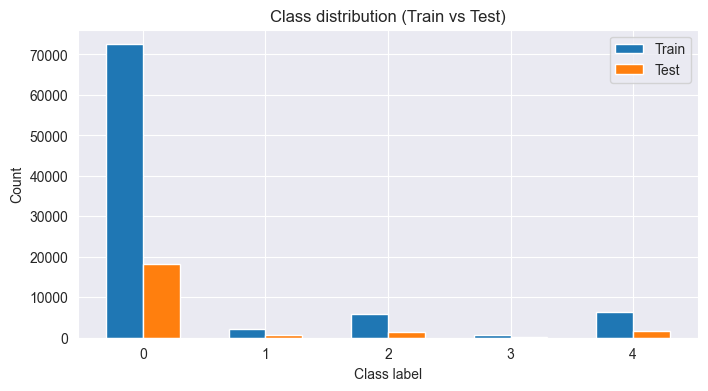

Train distribution:
 187
0    72471
1     2223
2     5788
3      641
4     6431
Name: count, dtype: int64

Test distribution:
 187
0    18118
1      556
2     1448
3      162
4     1608
Name: count, dtype: int64


In [54]:
# Class Imbalances + Bar Plots
train_counts = y_train.value_counts().sort_index()
test_counts  = y_test.value_counts().sort_index()

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(train_counts.index - 0.15, train_counts.values, width=0.3, label="Train")
ax.bar(test_counts.index + 0.15,  test_counts.values,  width=0.3, label="Test")
ax.set_title("Class distribution (Train vs Test)")
ax.set_xlabel("Class label")
ax.set_ylabel("Count")
ax.legend()
plt.show()

print("Train distribution:\n", train_counts)
print("\nTest distribution:\n", test_counts)

In [55]:
# Range Checks + the scan for the wired values
global_min = X_train.min().min()
global_max = X_train.max().max()

outside_range = ((X_train < 0) | (X_train > 1)).sum().sum()

print("Global min:", global_min)
print("Global max:", global_max)
print("Values outside [0, 1] in TRAIN:", outside_range)

# how many exact zeros/ones (sometimes indicates padding/clipping)
zeros = (X_train == 0).sum().sum()
ones  = (X_train == 1).sum().sum()
total_vals = X_train.size

print("Exact zeros:", zeros, f"({zeros/total_vals:.3%})")
print("Exact ones :", ones,  f"({ones/total_vals:.3%})")

Global min: 0.0
Global max: 1.0
Values outside [0, 1] in TRAIN: 0
Exact zeros: 6687424 (40.845%)
Exact ones : 89617 (0.547%)


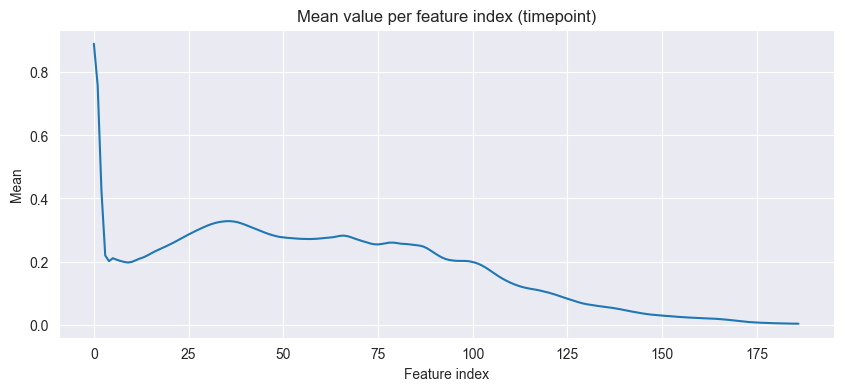

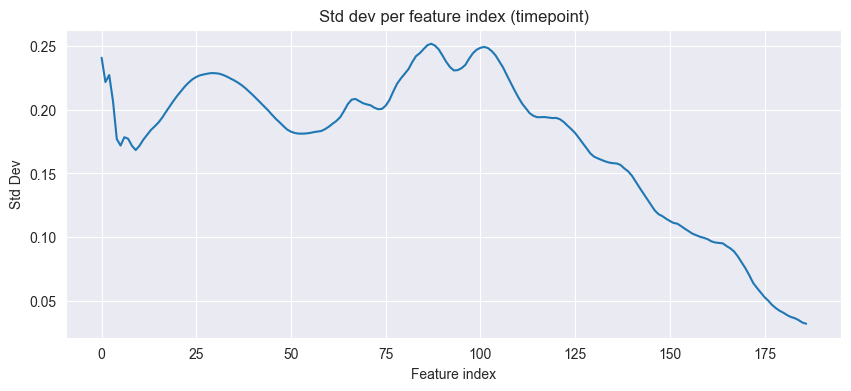

Any zero-variance columns? 0


In [56]:
# Feature summary (mean/std across timepoints)
feat_mean = X_train.mean(axis=0)
feat_std  = X_train.std(axis=0)

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(feat_mean.values)
ax.set_title("Mean value per feature index (timepoint)")
ax.set_xlabel("Feature index")
ax.set_ylabel("Mean")
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(feat_std.values)
ax.set_title("Std dev per feature index (timepoint)")
ax.set_xlabel("Feature index")
ax.set_ylabel("Std Dev")
plt.show()

print("Any zero-variance columns?", int((feat_std == 0).sum()))

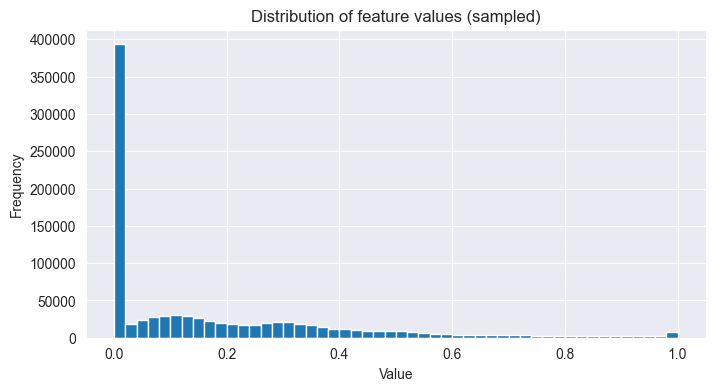

In [57]:
# Overall Value distribution (Histogram)
sample_vals = X_train.sample(n=min(5000, len(X_train)), random_state=42).to_numpy().ravel()

plt.figure(figsize=(8,4))
plt.hist(sample_vals, bins=50)
plt.title("Distribution of feature values (sampled)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

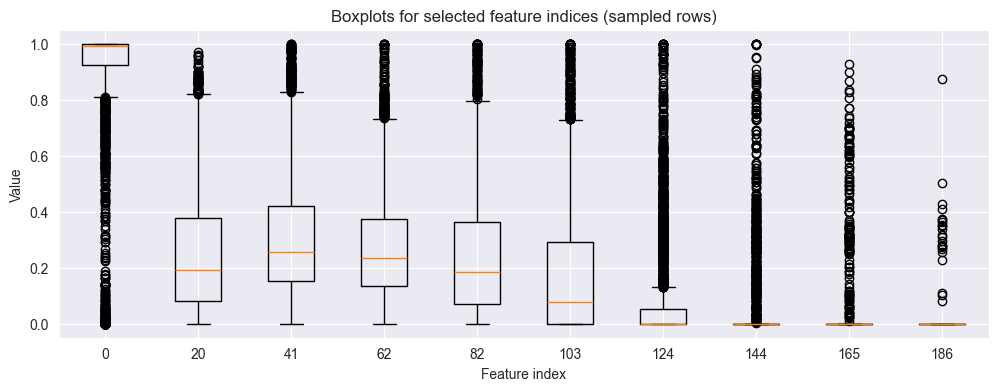

In [58]:
# Box Plots
# Pick a few feature indices spread across the signal
idx = np.linspace(0, X_train.shape[1]-1, 10, dtype=int)
box_data = X_train.iloc[:, idx].sample(n=min(3000, len(X_train)), random_state=42)

plt.figure(figsize=(12,4))
plt.boxplot([box_data.iloc[:, i] for i in range(box_data.shape[1])],
            tick_labels=idx, showfliers=True)
plt.title("Boxplots for selected feature indices (sampled rows)")
plt.xlabel("Feature index")
plt.ylabel("Value")
plt.show()

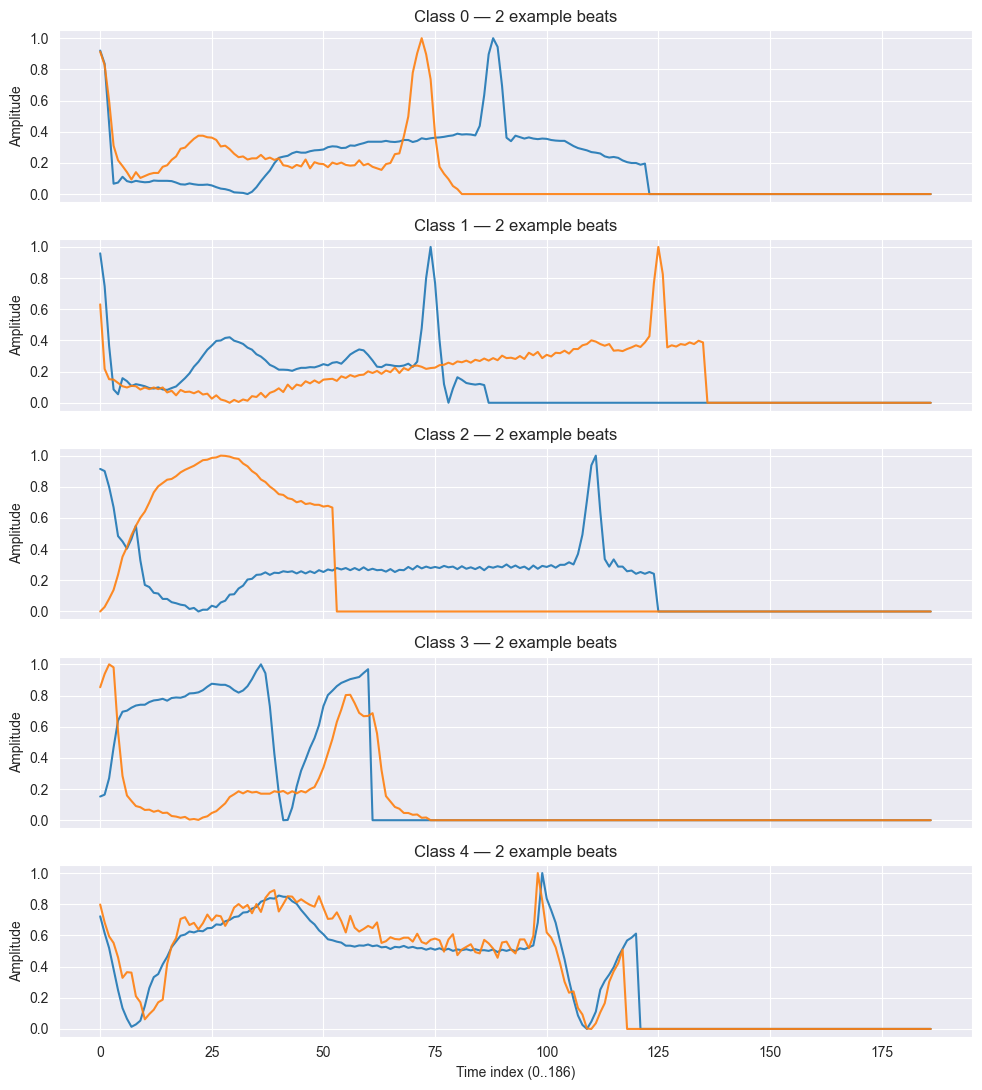

In [59]:
# Lets plot a few ECG Beats
def plot_examples_per_class(X, y, n_per_class=2, seed=42):
    rng = np.random.default_rng(seed)
    classes = sorted(y.unique())
    fig, axes = plt.subplots(len(classes), 1, figsize=(10, 2.2*len(classes)), sharex=True)
    if len(classes) == 1:
        axes = [axes]

    for ax, c in zip(axes, classes):
        idxs = np.where(y.values == c)[0]
        pick = rng.choice(idxs, size=min(n_per_class, len(idxs)), replace=False)
        for j in pick:
            ax.plot(X.iloc[j].values, alpha=0.9)
        ax.set_title(f"Class {c} — {min(n_per_class, len(idxs))} example beats")
        ax.set_ylabel("Amplitude")
    axes[-1].set_xlabel("Time index (0..186)")
    plt.tight_layout()
    plt.show()

plot_examples_per_class(X_train, y_train, n_per_class=2)

## Step — Train/Validation Split

We already have a separate Kaggle test file (`mitbih_test.csv`).
But we still create a **validation split from the training set** to:
- tune choices (baseline tree vs bagging)
- avoid peeking at the test set

We will use **stratified split** because classes are imbalanced.

In [60]:
X = df_train.iloc[:, :-1].astype(float)
y = df_train.iloc[:, -1].astype(int)

X_kaggle_test = df_test.iloc[:, :-1].astype(float)
y_kaggle_test = df_test.iloc[:, -1].astype(int)

print(X.shape, y.shape, X_kaggle_test.shape, y_kaggle_test.shape)

(87554, 187) (87554,) (21892, 187) (21892,)


In [61]:
# Stratified Train/Test Split
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_tr.shape, "Val:", X_val.shape)
print("Train label counts:\n", y_tr.value_counts().sort_index())
print("\nVal label counts:\n", y_val.value_counts().sort_index())

Train: (70043, 187) Val: (17511, 187)
Train label counts:
 187
0    57977
1     1778
2     4630
3      513
4     5145
Name: count, dtype: int64

Val label counts:
 187
0    14494
1      445
2     1158
3      128
4     1286
Name: count, dtype: int64


## Baseline 1 — Single Decision Tree

Decision Trees can overfit (high variance), especially if deep/unpruned.
We use it as a baseline to compare against Bagging.

Because classes are imbalanced, we use `class_weight="balanced"`.

In [62]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    random_state=42,
    class_weight="balanced"
)

dt.fit(X_tr, y_tr)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [63]:
# Now to Evaluate baseline tree on VAL
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
import numpy as np

pred_dt = dt.predict(X_val)

print("Decision Tree (VAL)")
print("Accuracy:", accuracy_score(y_val, pred_dt))
print("Balanced Accuracy:", balanced_accuracy_score(y_val, pred_dt))
print("\nClassification report:\n", classification_report(y_val, pred_dt))

Decision Tree (VAL)
Accuracy: 0.9559705328079493
Balanced Accuracy: 0.8285183294505261

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     14494
           1       0.70      0.66      0.68       445
           2       0.85      0.86      0.86      1158
           3       0.64      0.70      0.67       128
           4       0.94      0.95      0.94      1286

    accuracy                           0.96     17511
   macro avg       0.82      0.83      0.83     17511
weighted avg       0.96      0.96      0.96     17511



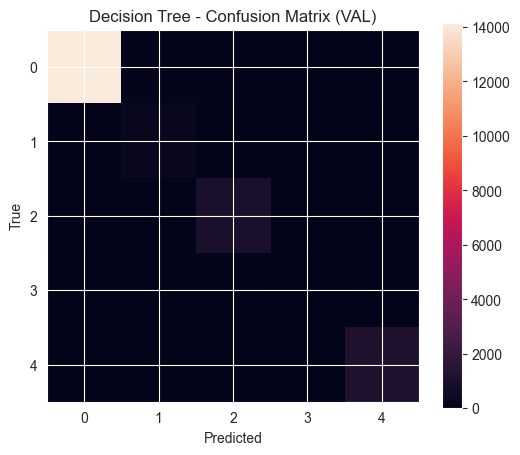

[[14140   120   138    40    56]
 [  136   295     8     1     5]
 [  135     3   996     8    16]
 [   25     0    13    89     1]
 [   51     3    12     0  1220]]


In [64]:
# Confusion Matrix Plot (VAL)
cm_dt = confusion_matrix(y_val, pred_dt)

plt.figure(figsize=(6,5))
plt.imshow(cm_dt)
plt.title("Decision Tree - Confusion Matrix (VAL)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.xticks(np.arange(len(np.unique(y))), np.unique(y))
plt.yticks(np.arange(len(np.unique(y))), np.unique(y))
plt.show()

print(cm_dt)

## Model 2 — BaggingClassifier (Decision Trees)

Bagging trains many trees on bootstrap samples and aggregates predictions.
This reduces the variance of a single decision tree and usually improves generalization.

In [65]:
import sklearn
from sklearn.ensemble import BaggingClassifier

print("scikit-learn version:", sklearn.__version__)

base_tree = DecisionTreeClassifier(
    random_state=42,
    class_weight="balanced"
)

# Compatibility: estimator (new) vs base_estimator (old)
try:
    bag = BaggingClassifier(
        estimator=base_tree,
        n_estimators=200,
        max_samples=0.8,
        max_features=1.0,
        bootstrap=True,
        oob_score=True,
        random_state=42,
        n_jobs=-1
    )
except TypeError:
    bag = BaggingClassifier(
        base_estimator=base_tree,
        n_estimators=200,
        max_samples=0.8,
        max_features=1.0,
        bootstrap=True,
        oob_score=True,
        random_state=42,
        n_jobs=-1
    )

bag.fit(X_tr, y_tr)

scikit-learn version: 1.7.2


,estimator,DecisionTreeC...ndom_state=42)
,n_estimators,200
,max_samples,0.8
,max_features,1.0
,bootstrap,True
,bootstrap_features,False
,oob_score,True
,warm_start,False
,n_jobs,-1
,random_state,42
,verbose,0


In [66]:
# Now to evaluate the Bagging on VAL
pred_bag = bag.predict(X_val)

print("Bagging (VAL)")
print("Accuracy:", accuracy_score(y_val, pred_bag))
print("Balanced Accuracy:", balanced_accuracy_score(y_val, pred_bag))
print("\nClassification report:\n", classification_report(y_val, pred_bag))

if hasattr(bag, "oob_score_"):
    print("\nOOB score:", bag.oob_score_)

Bagging (VAL)
Accuracy: 0.9755582205470847
Balanced Accuracy: 0.8257553449884408

Classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     14494
           1       0.96      0.62      0.76       445
           2       0.97      0.89      0.93      1158
           3       0.94      0.66      0.77       128
           4       0.99      0.96      0.98      1286

    accuracy                           0.98     17511
   macro avg       0.97      0.83      0.88     17511
weighted avg       0.98      0.98      0.97     17511


OOB score: 0.9727453135930786


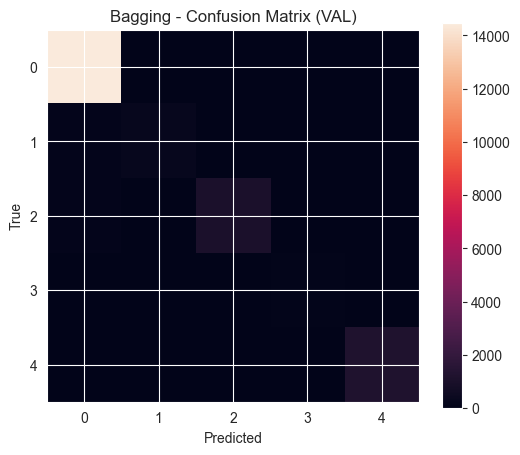

[[14455     9    23     0     7]
 [  164   278     3     0     0]
 [  117     2  1029     5     5]
 [   34     0    10    84     0]
 [   48     0     1     0  1237]]


In [67]:
# Confusion Matrix plot (VAL)
cm_bag = confusion_matrix(y_val, pred_bag)

plt.figure(figsize=(6,5))
plt.imshow(cm_bag)
plt.title("Bagging - Confusion Matrix (VAL)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.xticks(np.arange(len(np.unique(y))), np.unique(y))
plt.yticks(np.arange(len(np.unique(y))), np.unique(y))
plt.show()

print(cm_bag)

In [68]:
# Now to Compare the Decision Tree VS Bagging Cleanly
from sklearn.metrics import f1_score

rows = []

rows.append({
    "Model": "Decision Tree",
    "Accuracy": accuracy_score(y_val, pred_dt),
    "BalancedAcc": balanced_accuracy_score(y_val, pred_dt),
    "F1_macro": f1_score(y_val, pred_dt, average="macro"),
    "F1_weighted": f1_score(y_val, pred_dt, average="weighted")
})

rows.append({
    "Model": "Bagging (Trees)",
    "Accuracy": accuracy_score(y_val, pred_bag),
    "BalancedAcc": balanced_accuracy_score(y_val, pred_bag),
    "F1_macro": f1_score(y_val, pred_bag, average="macro"),
    "F1_weighted": f1_score(y_val, pred_bag, average="weighted")
})

pd.DataFrame(rows)

,Model,Accuracy,BalancedAcc,F1_macro,F1_weighted
0,Decision Tree,0.955971,0.828518,0.825465,0.955898
1,Bagging (Trees),0.975558,0.825755,0.883854,0.974132


## Final Evaluation on Kaggle Test Set

Now that we chose the better model using validation,
we retrain on the full training dataset (`mitbih_train.csv`)
and finally evaluate on `mitbih_test.csv`.

In [69]:
dt_final = DecisionTreeClassifier(random_state=42, class_weight="balanced")
dt_final.fit(X, y)

try:
    bag_final = BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42, class_weight="balanced"),
        n_estimators=300,
        max_samples=0.8,
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )
except TypeError:
    bag_final = BaggingClassifier(
        base_estimator=DecisionTreeClassifier(random_state=42, class_weight="balanced"),
        n_estimators=300,
        max_samples=0.8,
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )

bag_final.fit(X, y)

,estimator,DecisionTreeC...ndom_state=42)
,n_estimators,300
,max_samples,0.8
,max_features,1.0
,bootstrap,True
,bootstrap_features,False
,oob_score,False
,warm_start,False
,n_jobs,-1
,random_state,42
,verbose,0


In [70]:
# Test Set Results
pred_dt_test  = dt_final.predict(X_kaggle_test)
pred_bag_test = bag_final.predict(X_kaggle_test)

print("=== Kaggle Test Results ===")

print("\nDecision Tree (TEST)")
print("Accuracy:", accuracy_score(y_kaggle_test, pred_dt_test))
print("Balanced Accuracy:", balanced_accuracy_score(y_kaggle_test, pred_dt_test))
print(classification_report(y_kaggle_test, pred_dt_test))

print("\nBagging (TEST)")
print("Accuracy:", accuracy_score(y_kaggle_test, pred_bag_test))
print("Balanced Accuracy:", balanced_accuracy_score(y_kaggle_test, pred_bag_test))
print(classification_report(y_kaggle_test, pred_bag_test))

=== Kaggle Test Results ===

Decision Tree (TEST)
Accuracy: 0.9554631828978623
Balanced Accuracy: 0.8063428445546889
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     18118
           1       0.70      0.66      0.68       556
           2       0.86      0.86      0.86      1448
           3       0.60      0.59      0.60       162
           4       0.94      0.94      0.94      1608

    accuracy                           0.96     21892
   macro avg       0.82      0.81      0.81     21892
weighted avg       0.96      0.96      0.96     21892


Bagging (TEST)
Accuracy: 0.9733692673122601
Balanced Accuracy: 0.8066963143419859
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18118
           1       0.95      0.61      0.74       556
           2       0.97      0.89      0.92      1448
           3       0.81      0.59      0.69       162
           4       0.99      0.94      0